In [1]:
letterR_url = "https://www.google.com/url?sa=i&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwim6rO0q9fgAhVKeKwKHThBAmAQjRx6BAgBEAU&url=https%3A%2F%2Fwww.typoland.cz%2Fen%2Fwooden-letters-black%2F313-wooden-letter-r-black.html&psig=AOvVaw3j1sPP23kUuim1n7lXLS-U&ust=1551199679589930"

### Affine Image Transformations in Python with Numpy, Pillow and OpenCV

In this article I will be describing what it means to apply an affine transformation to an image and how to do it in Python. First I will demonstrate the low level operations in Numpy to give a detailed geometric implementation. Then I will segue those into a more practical usage of the Python Pillow and OpenCV libraries. 

This article was written using a Jupyter notebook and the source can be found at my [GitHub repo](https://github.com/amcquistan/affine-image-transforms-python) so, please feel free to clone / fork it and experiment with the code.

### What is an Affine Transformation

According to [Wikipedia](https://en.wikipedia.org/wiki/Affine_transformation) an affine transformation is a functional mapping between two geometric (affine) spaces which preserve points, straight and parallel lines as well as ratios between points. All that mathy abstract wording boils down is a loosely speaking linear transformation that results in, at least in the context of image processing, one or more manipulations like rotating, flipping, scaling or shearing by applying a transformation matrix.

One good thing is that since this is essentially a 2D geometric operation we can visualize it. Let me start off by giving a table of affine transformations that describe each type of geometric manipulation.

<table>
    <thead>
        <tr>
            <th>Transformation Type</th>
            <th>Transformation Matrix</th>
            <th>Pixel Mapping Equation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Identity</td>
            <td>
            $$
                \begin{bmatrix}
                1 & 0 & 0 \\ 
                0 & 1 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
            $$
            </td>
            <td>
                $$x^{'} = x$$ <br> $$y^{'} = y$$
            </td>
        </tr>
        <tr>
            <td>Scaling</td>
            <td>
            $$
                \begin{bmatrix}
                c_{x} & 0 & 0 \\ 
                0 & c_{y} & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
            $$
            </td>
            <td>
                $$x^{'} = c_{x} * x$$ <br> $$y^{'} = c_{y} * y$$
            </td>
        </tr>
        <tr>
            <td>Rotation*</td>
            <td>
            $$
                \begin{bmatrix}
                cos \Theta & sin \Theta & 0 \\ 
                -sin \Theta & cos \Theta & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
            $$
            </td>
            <td>
                $$x^{'} = x * cos \Theta - y * sin \Theta$$ <br> $$y^{'} = x * cos \Theta + y * sin \Theta$$
            </td>
        </tr>
        <tr>
            <td>Translation</td>
            <td>
            $$
                \begin{bmatrix}
                1 & 0 & t_{x} \\ 
                0 & 1 & t_{y} \\ 
                0 & 0 & 1 
                \end{bmatrix}
            $$
            </td>
            <td>
                $$x^{'} = x + t_{x}$$ <br> $$y^{'} = y + t_{y}$$
            </td>
        </tr>
        <tr>
            <td>Horizontal Shear</td>
            <td>
            $$
                \begin{bmatrix}
                1 & s_{h} & 0 \\ 
                0 & 1 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
            $$
            </td>
            <td>
                $$x^{'} = x + s_{v} * y$$ <br> $$y^{'} = y$$
            </td>
        </tr>
        <tr>
            <td>Vertical Shear</td>
            <td>
            $$
                \begin{bmatrix}
                1 & 0 & 0 \\ 
                s_{v} & 1 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
            $$
            </td>
            <td>
                $$x^{'} = x$$ <br> $$y^{'} = x * s_{h} + y$$
            </td>
        </tr>
    </tbody>
</table>

\* affine transformation uses angle of rotation that is clockwise which is in contrast to the typical geometry unit circle of angles being measured in counter clockwise rotation with 0 starting from the positive X axis, therefore you will see that the negative of the angle is often applied.

' notation here is just referring to the transformed output coordinate of x or y not the calculus notation for a derivative

For means of simple demonstration I will apply a couple transformations to manipulate the x and y coordinates of the following points which have three dimensional components of x, y and ascii character index similar to the way an image pixel has 3 dimensional components of x, y, and frequency (or intensity). 

a = (0, 1, 0)
b = (1, 0, 1)
c = (0, -1, 2)
d = (-1, 0, 3)

The transformations for this example will be Scaling by 2 in all directions and rotation of 90 degrees clockwise. First I will perform the transformations individually to show the direct effect each has on moving the points around then I will combine the transformations and apply them in one action.

To begin I want to build a Numpy array (some may call this a matrix) with each row representing the point where the first column is the x, the second the y, and the third is the index of its letter in the ascii character set similar to the table shown below. Next I use [Matplotlib](https://matplotlib.org/) to plot the points (after applying the unchanging Identity transformation) to give a baseline visual of where we stand.

<table>
    <thead>
        <tr><th>Point</th><th>x (row)</th><th>y (column)</th><th>ascii index</th></tr>
    </thead>
    <tbody>
        <tr><td>a</td><td>0</td><td>1</td><td>0</td></tr>
        <tr><td>b</td><td>1</td><td>0</td><td>1</td></tr>
        <tr><td>c</td><td>0</td><td>-1</td><td>2</td></tr>
        <tr><td>d</td><td>-1</td><td>0</td><td>3</td></tr>
    </tbody>
</table>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import string

# points a, b and, c
a, b, c, d = (0, 1, 0), (1, 0, 1), (0, -1, 2), (-1, 0, 3)

# matrix with row vectors of points
A = np.array([a, b, c, d])

# 3x3 Identity transformation matrix
I = np.eye(3)

In [8]:
I,A
for row in A:
    output_row = I@ row
    print(I, row, output_row)
    

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [0 1 0] [0. 1. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [1 0 1] [1. 0. 1.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [ 0 -1  2] [ 0. -1.  2.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-1  0  3] [-1.  0.  3.]


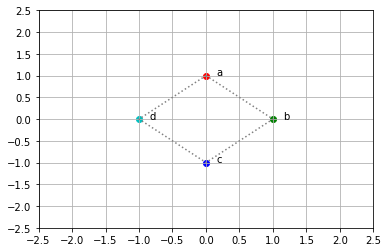

In [3]:
color_lut = 'rgbc'
fig = plt.figure()
ax = plt.gca()
xs = []
ys = []
for row in A:
    output_row = I @ row
    x, y, i = output_row
    xs.append(x)
    ys.append(y)
    i = int(i) # convert float to int for indexing
    c = color_lut[i]
    plt.scatter(x, y, color=c)
    plt.text(x + 0.15, y, f"{string.ascii_letters[i]}")
xs.append(xs[0])
ys.append(ys[0])
plt.plot(xs, ys, color="gray", linestyle='dotted')
ax.set_xticks(np.arange(-2.5, 3, 0.5))
ax.set_yticks(np.arange(-2.5, 3, 0.5))
plt.grid()
plt.show()

The three points a, b, and c plotted on a grid after applying the Identity transformation to them via a simple vector matrix dot product leaving them unchanged.  

I will now move on to creating a scaling transformation matrix T_s (shown below) which scales the placement of the points in all directions.

$$
                T_s = \begin{bmatrix}
                2 & 0 & 0 \\ 
                0 & 2 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
$$

Now I will move on to plotting the transformed points similar to what was done with the original points unaltered by the Identity transformation but, this time I will apply the scaling transformation matrix defined above. For a better visualization, I plot a dotted line connecting the points.

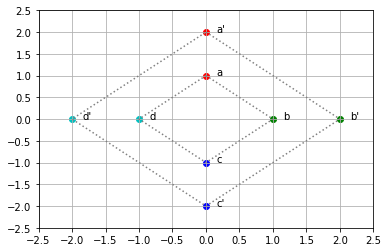

In [4]:
# create the scaling transformation matrix
T_s = np.array([[2, 0, 0], [0, 2, 0], [0, 0, 1]])

fig = plt.figure()
ax = plt.gca()
xs_s = []
ys_s = []
for row in A:
    output_row = T_s @ row
    x, y, i = row
    x_s, y_s, i_s = output_row
    xs_s.append(x_s)
    ys_s.append(y_s)
    i, i_s = int(i), int(i_s) # convert float to int for indexing
    c, c_s = color_lut[i], color_lut[i_s] # these are the same but, its good to be explicit
    plt.scatter(x, y, color=c)
    plt.scatter(x_s, y_s, color=c_s)
    plt.text(x + 0.15, y, f"{string.ascii_letters[int(i)]}")
    plt.text(x_s + 0.15, y_s, f"{string.ascii_letters[int(i_s)]}'")

xs_s.append(xs_s[0])
ys_s.append(ys_s[0])
plt.plot(xs, ys, color="gray", linestyle='dotted')
plt.plot(xs_s, ys_s, color="gray", linestyle='dotted')
ax.set_xticks(np.arange(-2.5, 3, 0.5))
ax.set_yticks(np.arange(-2.5, 3, 0.5))
plt.grid()
plt.show()

From the plot above it should be very clear that the x and y dimensions were simply scaled up by a factor of two while the third dimension responsible for the ascii letter index was left unchanged.  In fact, those familiar with matrix algebra will have noticed that for all of the affine transformations listed in the first table the value represented in the third dimension is always left un altered as indicated by the all zeros and lone one value in the third dimension index of the last column. 

Now let me describe how to interpret the rotation transformation. I will start by solving the two trigonometric functions for the desired angle of rotation of 90 degrees then I simply plug them into the rotation transformation matrix listed in the previous table. 

$$
sin (90^{o}) = 1
$$

$$
cos (90^{o}) = 0
$$

$$
                T_s = \begin{bmatrix}
                0 & 1 & 0 \\ 
                -1 & 0 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
$$

Now all I need to do is apply the same logic to transform and plot the points like so.

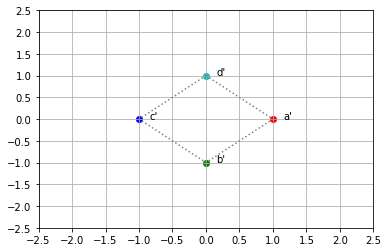

In [5]:
# create the rotation transformation matrix
T_r = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])

fig = plt.figure()
ax = plt.gca()
for row in A:
    output_row = T_r @ row 
    x_r, y_r, i_r = output_row
    i_r = int(i_r) # convert float to int for indexing
    c_r = color_lut[i_r] # these are the same but, its good to be explicit
    letter_r = string.ascii_letters[i_r]
    plt.scatter(x_r, y_r, color=c_r)
    plt.text(x_r + 0.15, y_r, f"{letter_r}'")

plt.plot(xs, ys, color="gray", linestyle='dotted')
ax.set_xticks(np.arange(-2.5, 3, 0.5))
ax.set_yticks(np.arange(-2.5, 3, 0.5))
plt.grid()
plt.show()

Hopefully you can tell from the plot that all points were rotated 90 degrees around an axis of rotation at the origin.

The neat thing about affine transformations being essentially linear transformations is that you can combine the transformations and apply them in one step.  To demonstrate this I will apply the dot product (matrix multiplication) of my two transformation matrices like. 

$$
                T_{comb} = \begin{bmatrix}
                0 & 1 & 0 \\ 
                -1 & 0 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix} * 
                \begin{bmatrix}
                2 & 0 & 0 \\ 
                0 & 2 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix} = 
                \begin{bmatrix}
                0 & 2 & 0 \\ 
                -2 & 0 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
$$


Now I can apply this combined transformation matrix to the points and replot them to show a combination of scaling by two and rotation by 90 degrees.



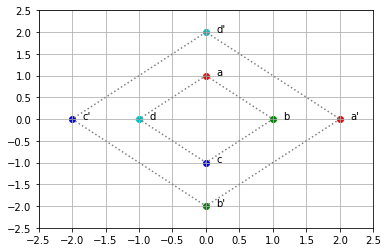

In [6]:
# create combined tranformation matrix
T = T_s @ T_r

fig = plt.figure()
ax = plt.gca()

xs_comb = []
ys_comb = []
for row in A:
    output_row = T @ row
    x, y, i = row
    x_comb, y_comb, i_comb = output_row
    xs_comb.append(x_comb)
    ys_comb.append(y_comb)
    i, i_comb = int(i), int(i_comb) # convert float to int for indexing
    c, c_comb = color_lut[i], color_lut[i_comb] # these are the same but, its good to be explicit
    letter, letter_comb = string.ascii_letters[i], string.ascii_letters[i_comb]
    plt.scatter(x, y, color=c)
    plt.scatter(x_comb, y_comb, color=c_comb)
    plt.text(x + 0.15 , y, f"{letter}")
    plt.text(x_comb + 0.15, y_comb, f"{letter_comb}'")
xs_comb.append(xs_comb[0])
ys_comb.append(ys_comb[0])
plt.plot(xs, ys, color="gray", linestyle='dotted')
plt.plot(xs_comb, ys_comb, color="gray", linestyle='dotted')
ax.set_xticks(np.arange(-2.5, 3, 0.5))
ax.set_yticks(np.arange(-2.5, 3, 0.5))
plt.grid()
plt.show()

### Working with an Image

By I now hope that I've been able to build up some intuition about how affine transformations are used to simply move around points in 2D space so, with that out of the way I'd like to start working with some real image data to give a more concrete demonstration of how all this works. This also allows me to cover another important topic of affine transformations which deals with the third dimension. The third dimension of data in an image represents the actual pixel value or sometimes referred to as the intensity domain where as the physical 2D location of the pixels in the other two dimensions are referred to as the spatial domain.

To begin I will read in and display an image using matplotlib which is simply a large capital letter R.

In [7]:
img = plt.imread('letterR.jpg')
img.shape

(1000, 1000, 4)

Using the `imread(...)` method I am able to read in the JPG image representing the capital letter R into a numpy ndarray. I then display the dimensions of the array which are 1000 rows by 1000 columns together making up 1,000,000 pixels locations in the spatial domain. The individual pixel data is then in the form of an array of 4 unsigned integers representing a red, green, blue and alpha channel (or sample) that together provide the intensity data of each pixel.

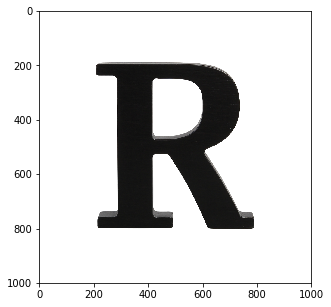

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(img)

Next I would like to apply the previous scale and rotation to the spatial domain of the image data thus transforming the pixel locations similar to what I demonstrated earlier with the points data.  However, I need to take a slightly different approach because the image data is organized in a different way than that of the rows of data points I worked with earlier.  With the image data I need to map the indices for each pixel of the input data to the transformed output indices using the transformation matrix T defined earlier. 

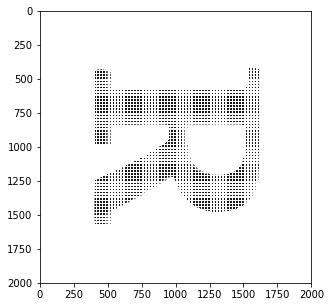

In [9]:
# 2x scaling requires a tranformation image array 2x the original image
img_transformed = np.empty((2000, 2000, 4), dtype=np.uint8)
for i, row in enumerate(img):
    for j, col in enumerate(row):
        pixel_data = img[i, j, :]
        input_coords = np.array([i, j, 1])
        i_out, j_out, _ = T @ input_coords
        img_transformed[i_out, j_out, :] = pixel_data

plt.figure(figsize=(5, 5))
plt.imshow(img_transformed)

Plotting the image after applying the transformation clearly shows that the original image has been rotated 90 degrees clockwise and scaled up 2X. However, the result is now obviously diminished as you can easily see discontinuity in the pixel intensities.  

To understand the reason for this I will again utilize a simple grid plot for demonstration. Consider a plot of 4 squares in a 2x2 grid similar to the spatial domain of a 2x2 image.

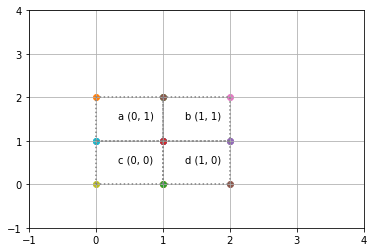

In [10]:
def plot_box(plt, x0, y0, txt, w=1, h=1):
    plt.scatter(x0, y0)
    plt.scatter(x0, y0 + h)
    plt.scatter(x0 + w, y0 + h)
    plt.scatter(x0 + w, y0)
    plt.plot([x0, x0, x0 + w, x0 + w, x0], [y0, y0 + h, y0 + h, y0, y0], color="gray", linestyle='dotted')
    plt.text(x0 + (.33 * w), y0 + (.5 * h), txt)

#             x0, y0, letter
a = np.array((0,  1,  0))
b = np.array((1,  1,  1))
c = np.array((0,  0,  2))
d = np.array((1,  0,  3))

A = np.array([a, b, c, d])
fig = plt.figure()
ax = plt.gca()
for pt in A: 
    x0, y0, i = I @ pt
    x0, y0, i = int(x0), int(y0), int(i)
    plot_box(plt, x0, y0, f"{string.ascii_letters[int(i)]} ({x0}, {y0})")

ax.set_xticks(np.arange(-1, 5, 1))
ax.set_yticks(np.arange(-1, 5, 1))
plt.grid()
plt.show()

Now watch what happens when I apply a 2X scaling transformation as depicted below. Recall that:

$$
        T_s = \begin{bmatrix}
                2 & 0 & 0 \\ 
                0 & 2 & 0 \\ 
                0 & 0 & 1 
                \end{bmatrix}
$$

You will notice that such a spatial transformation results in ... well gaps to put it in simple terms which I've made obvious by plotting question marks along with the coordinates.  The 2x2 grid is transformed into a 3x3 grid with the original squares being repositioned based of the linear transformation applied. This means that (0,0) * $T_s$ remains (0,0) because its properties as a 0 vector but, all others are scaled by two such as (1,1) * $T_s$ -> (2,2).

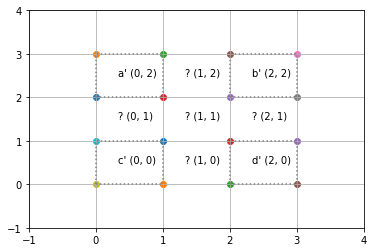

In [11]:
fig = plt.figure()
ax = plt.gca()
for pt in A: 
    xt, yt, i = T_s @ pt
    xt, yt, i = int(xt), int(yt), int(i)
    plot_box(plt, xt, yt, f"{string.ascii_letters[i]}' ({xt}, {yt})")

delta_w, delta_h = 0.33, 0.5
plt.text(0 + delta_w, 1 + delta_h, "? (0, 1)")
plt.text(1 + delta_w, 0 + delta_h, "? (1, 0)")
plt.text(1 + delta_w, 1 + delta_h, "? (1, 1)")
plt.text(1 + delta_w, 2 + delta_h, "? (1, 2)")
plt.text(2 + delta_w, 1 + delta_h, "? (2, 1)")

ax.set_xticks(np.arange(-1, 5, 1))
ax.set_yticks(np.arange(-1, 5, 1))
plt.grid()
plt.show()

The question remains of what to do with those gaps that have been introduced? An intuitive thought would be to simply look to the original image for the answer.  It just so happens that if we apply the inverse of the transformation to a coordinate in the output I will get the corresponding location of the original input.  

In matrix operations such as backwards mapping looks like this.

$$
(x, y, 1) = T_s^{-1} * (x' y' 1)
$$

where x', y' are the coordinates int the above transformed 3x3 grid, specifically the a missing location such as (2, 1), $T_s^{-1}$ (actual values shown below) is the inverse of the 2x scaling matrix $T_s$ and x, y are the coordinates that are found in the original 2x2 grid.

$$
T_s^{-1} = \begin{bmatrix}
 1/2 & 0 & 0 \\ 
 0 & 1/2 & 0 \\
 0 & 0 & 1
\end{bmatrix}^{-1}
$$

However, you will soon realize there is a bit of an issue that still needs sorted out due to the fact that each of the gap's coordinates map back to fractional values of the 2x2 coordinate system.  In the case of image data you can't really have a fraction of a pixel.  This will be clearer with an example of mapping the (2, 1) gap back to the original 2x2 space like so.

$$
T_s^{-1} * (2, 1, 1) = (1, 1/2, 1)
$$

In this case I will round the y' = 1/2 down to 0 and say that that maps to (1, 0). In the general sense this method of selecting a value in the original 2x2 grid to put into the gaps of the transformed 3x3 grid is known as interpolation, and in this specific example I am using a simplified version of the nearest neighbor interpolation method.

Ok, now back to the image data.  It should be fairly clear what should be done now to fix those gaps in the scaled and rotated version of the letter R. I must develop an implementation of nearest neighbor interpolation based off the backwards mapping, using the inverse of the transformation matrix T, of the pixel coordinates in the transformed image to find either the exact match or nearest neighbor in the original image.

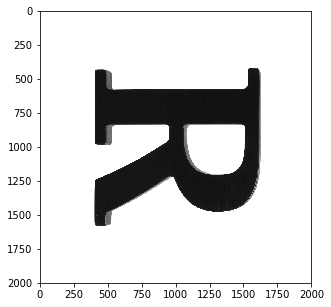

In [12]:
T_inv = np.linalg.inv(T)

# nearest neighbors interpolation
def nearest_neighbors(i, j, M, T_inv):
    x_max, y_max = M.shape[0] - 1, M.shape[1] - 1
    x, y, _ = T_inv @ np.array([i, j, 1])
    if np.floor(x) == x and np.floor(y) == y:
        x, y = int(x), int(y)
        return M[x, y]
    if np.abs(np.floor(x) - x) < np.abs(np.ceil(x) - x):
        x = int(np.floor(x))
    else:
        x = int(np.ceil(x))
    if np.abs(np.floor(y) - y) < np.abs(np.ceil(y) - y):
        y = int(np.floor(y))
    else:
        y = int(np.ceil(y))
    if x > x_max:
        x = x_max
    if y > y_max:
        y = y_max
    return M[x, y,]

img_nn = np.empty((2000, 2000, 4), dtype=np.uint8)
for i, row in enumerate(img_transformed):
    for j, col in enumerate(row):
        img_nn[i, j, :] = nearest_neighbors(i, j, img, T_inv)

plt.figure(figsize=(5, 5))
plt.imshow(img_nn)

Not too shabby right?

I should note that in most cases the nearest neighbor method will not be sufficient. There are two other more common interpolation methods known as bilinear and bicubic interpolation that generally provide much better results.  I will speak more about these other interpolation algorithms when introducing the Pillow and OpenCV libraries in latter sections. The purpose of this section is just to build an intuitive understanding of how things work.

### Affine Transformations with Pillow

In this section I will be briefly covering how to use the excellent Python image processing library Pillow to perform affine transformations.

First off Pillow will need to be installed. I used pip to accomplish this like so.

```sh
pip install pillow
```

Now first step is to import the Image class from the PIL (PIL is the name of the python module associated with Pillow) module and read in my image.

In [13]:
from PIL import Image

To read in the sample image file name "letterR.jpg" I call the class method `Image.open(...)` passing it the filename which returns an instance of the `Image` class which I then convert to a numpy array and display with matplotlib.

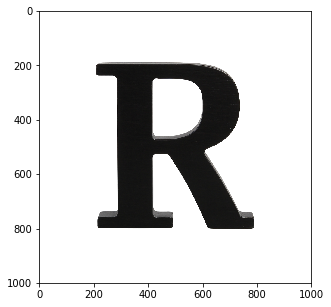

In [14]:
img = Image.open('letterR.jpg')
plt.figure(figsize=(5, 5))
plt.imshow(np.asarray(img))

The Pillow `Image` class has a handy method called `transform(...)` that allows you to perform fine grained affine transformations but, there are a few oddities that I must discuss first before I jump into a demonstration of it. The `transform(...)` method begins with two required parameters representing `size` as a tuple of height and width followed by the `method` of transformation to be applied which will be `Image.AFFINE` in this case.

The remaining parameters are optional keyword arguments that control how the transformation is to be performed. In the case of this example I will be using the `data` parameter which takes the first two rows of an affine transformation matrix.

For example, the 2x scaling transformation matrix I've been working with trimmed down to just the first two rows looks like this.

$$
        T_s = \begin{bmatrix}
                2 & 0 & 0 \\ 
                0 & 2 & 0
                \end{bmatrix}
$$

The last parameter that I will be using with the `transform(...)` method is `resample` which is used to indicate the type of pixel interpolation algorithm to apply out of the possible choices of `Image.NEAREST` (nearest neighbor), `Image.BILINEAR`, or `Image.BICUBIC`. This choice will often vary depending on the transformation being applied. However, bilinear and bicubic generally give better results than nearest neighbor but, as already demonstrated in this example nearest neighbor works quite well.

There are a few peculiarities that served as real gotchas for me the first time I used the `Image.transform(...)` method particularly around the construction of the affine transformation matrix with the weirdly truncated off last row.  Thus, I'd like to spend some time going over why things work the way they do because its a bit of a process.

First thing that must happen is the image must be translated so that the origin (0, 0) is in the middle of the image. In the case of the 1000 x 1000 image of the letter R in this example that means a translation of -500 in the x and y.

Below I show the generic translation transformation matrix $T_translate$ and the one I'll be using in the example $T_{neg500}$.

$$
        T_{translate} = \begin{bmatrix}
                1 & 0 & t_x \\ 
                0 & 1 & t_y \\
                0 & 0 & 1
                \end{bmatrix}
$$

$$
        T_{neg500} = \begin{bmatrix}
                1 & 0 & -500 \\ 
                0 & 1 & -500 \\
                0 & 0 & 1
                \end{bmatrix}       
$$

Then there are the 2X scaling $T_scale$ and 90 degree rotation $T_rotate$ matrices from before. However, the Pillow library actually decided to use standard geometric angles (ie, counter clockwise) rather than the clockwise rotations I described earlier so the signs on the of the sin functions flip. Below are the resultant individual transformation matrices.

$$
        T_{rotate} = \begin{bmatrix}
                0 & -1 & 0 \\ 
                1 & 0 & 0 \\
                0 & 0 & 1
                \end{bmatrix}       
$$

$$
        T_{scale} = \begin{bmatrix}
                2 & 0 & 0 \\ 
                0 & 2 & 0 \\
                0 & 0 & 1
                \end{bmatrix}
$$

Next another translation matrix needs to be applied which acts to reposition the spatial domain of the pixels essentially negating the first one that centered the origin.  In this case I need a positive translation of 1000 in the x and y where 1000 comes from twice the original because it has been scaled up by two.

$$
        T_{pos1000} = \begin{bmatrix}
                1 & 0 & 1000 \\ 
                0 & 1 & 1000 \\
                0 & 0 & 1
                \end{bmatrix}       
$$

These constitute the individual transformation steps that are required so, all that remains is to multiply the matrices in order (ie, right to left) like so.

$$
    T =         T_{pos1000} * T_{rotate} * T_{scale} * T_{neg500} 
$$

Ok, so there is actually one last oddity. The `Image.transform(...)` method actually requires the inverse of the transformation matrix be supplied to the `data` parameter as a flattened array (or tuple) excluding the last row.

$$
    T_{inv} = T^{-1}
$$

In code this all works as follows.

In [15]:

# recenter resultant image
T_pos1000 = np.array([
    [1, 0, 1000],
    [0, 1, 1000],
    [0, 0, 1]])
# rotate - opposite angle
T_rotate = np.array([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]])
# scale
T_scale = np.array([
    [2, 0, 0],
    [0, 2, 0],
    [0, 0, 1]])
# center original to 0,0
T_neg500 = np.array([
    [1, 0, -500],
    [0, 1, -500],
    [0, 0, 1]])
T = T_pos1000 @ T_rotate @ T_scale @ T_neg500
T_inv = np.linalg.inv(T)

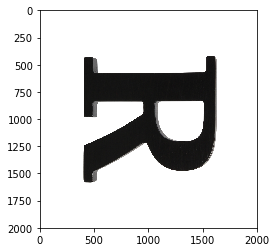

In [16]:
img_transformed = img.transform((2000, 2000), Image.AFFINE, data=T_inv.flatten()[:6], resample=Image.NEAREST)
plt.imshow(np.asarray(img_transformed))

### Affine Transformations with OpenCV2

Continuing on I would like to briefly describe how to carry out these affine transformations with the popular image processing and computer vision library OpenCV. I use the word brief here because it is largely the same as what is required in the previous description of using Pillow.

First things first you must install like so.

```sh
pip install opencv-python
```

As I mentioned above there is significant overlap in methodology between the Pillow approach and using OpenCV. For example, you still create a transformation matrix that first centers then uncenters the array of pixels to and from the origin and, you only use the first two rows of the transformation matrix. The major difference is that with OpenCV you give it the standard matrix rather than the inverse.

So, with that understanding laid out I will jump into the code starting with importing the opencv-python module which is named `cv2`.

In [17]:
import cv2

To read in the image is as simple as calling the `cv2.imread(...)` method passing the filename as an argument. This returns the image data in to form of a 3D numpy array similar to how matplotlib works but, the pixel data in the 3rd dimension is comprised of an array of channels in the order of blue, green, red instead of red, green, blue, alpha as was in the case of reading with matplotlib.

Thus, in order to plot the numpy image data originating from the OpenCV library one must reverse the order of the pixel channels. Luckily, OpenCV provides a convince method `cvtColor(...)` that can be used to do this as shown below (although numpy purists are likely to know that `img[:,:,::-1]` will do the same).

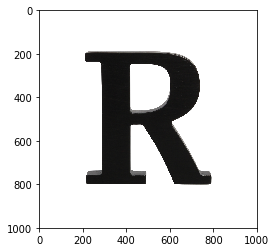

In [18]:
img = cv2.imread('letterR.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

A few last items to mention are that OpenCV requires the data in the transformation matrix to be of type 32 bit float rather than the default 64 bit float so, be sure to convert down to 32 bit with `numpy.float32(...)`. Also, the API to `cv2.warpAffine(...)` does not provide the ability to specify what type of pixel interpolation algorithm to apply I could not determine from the docs what is used. If you know or find out please post in the comments below.

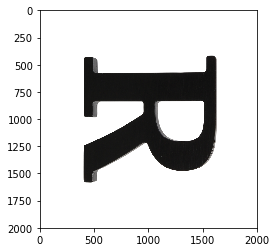

In [19]:
T_opencv = np.float32(T.flatten()[:6].reshape(2,3))
img_transformed = cv2.warpAffine(img, T_opencv, (2000, 2000))
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

### Conclusion

In this article I have covered what an affine transformation is and how it can be applied to image processing using Python. Pure numpy and matplotlib was used to give a low level intuitive description of how affine transformations work then I went on to demonstrate how the same can be done using two popular Python libraries Pillow and OpenCV.

Thanks for reading and as always don't be shy about commenting or critiquing below.